## Multi-platform streaming service

Users from a streaming company can watch streams from both its app and website. We are given a dataset containing the following user information:
- ``Time on App``: average time spent on application, in hours/week;
- ``Time on Website``: average time spent on the website, in hours/week;
- ``Length of Membership``: how long a client is subscribed to service, in years;
- ``Yearly Amount Spent``: average yearly expenditure, in dollars.

Understanding that the company wants to take action on maximizing profits, some questions arise from the dataset:
- Is the length of membership important?
- Should the company focus its investments on the app or the website?
- What other insights should be taken into consideration?

We will try and answer these questions throughout the study.

### Libraries and settings

All imports and settings used throughout the study are listed in the cell below.

In [2]:
# Data wrangling
import pandas as pd
import numpy as np

# Data visualization
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

custom_params = {
    "axes.spines.right": False, 
    "axes.spines.top": False,
    "patch.force_edgecolor": True,
}

# Pipelines
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn import set_config
set_config(display="diagram")

# Machine learning classifier and evaluation metrics
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import RANSACRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Statistical inference
import statsmodels.api as sm

### Data reading

We have a single `df` data frame (from _userInformation.csv_). The data summary shows that the four columns are numerical and continuous and have no missing values.

All questions we are trying to answer are geared towards maximizing profit. The only column describing monetary values is `Yearly Amount Spent`, and it will be assigned as our target.

Before analyzing the statistical summary, we separate a small sample from the data set (20% in this case) to function as a `test` dataset. This separation must be made early because it would incur _data leakage_ and thus our test set wouldn't give us an accurate measure of model performance.

We then will conduct exploratory data analysis on the `train` dataset.

In [3]:
# Reading and data summary
df = pd.read_csv('userInformation.csv')
df.info()

# Features and target
features = ['Time on App', 'Time on Website', 'Length of Membership']
target = 'Yearly Amount Spent'

# Separate 20% of observations as a test set
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=75)

# Regroup data in order to facilitate EDA
train = X_train.join(y_train) # type: ignore
print('\nStatistical summary on training set:\n')
train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Time on App           500 non-null    float64
 1   Time on Website       500 non-null    float64
 2   Length of Membership  500 non-null    float64
 3   Yearly Amount Spent   500 non-null    float64
dtypes: float64(4)
memory usage: 15.8 KB

Statistical summary on training set:



,Time on App,Time on Website,Length of Membership,Yearly Amount Spent
count,400.000000,400.000000,400.000000,400.000000
mean,12.045440,37.087295,3.534212,498.876104
std,0.966092,1.005641,1.003353,77.870618
min,8.668350,33.913847,0.789520,256.670582
25%,11.388637,36.373194,2.923353,445.577927
50%,12.026934,37.088123,3.532689,495.926762
75%,12.730343,37.727921,4.124835,549.039064
max,15.126994,40.005182,6.922689,765.518462


## Exploratory data analysis

We plot both the distributions and linear relationships for each possible feature and target pair. We can conclude that:
- From the plot, we can conclude that all columns are *normally distributed* without any apparent
- `Yearly Amount Spent` has a strong association with `Time on App` and an even stronger association with `Length of Membership`. It also showed *no association* with `Time on Website`.
- `Length of Membership` has a weak positive association with `Time on App` and a weak negative association with `Time on Website`. It seems as if long-time users prefer watching streams on the app rather than on the website.

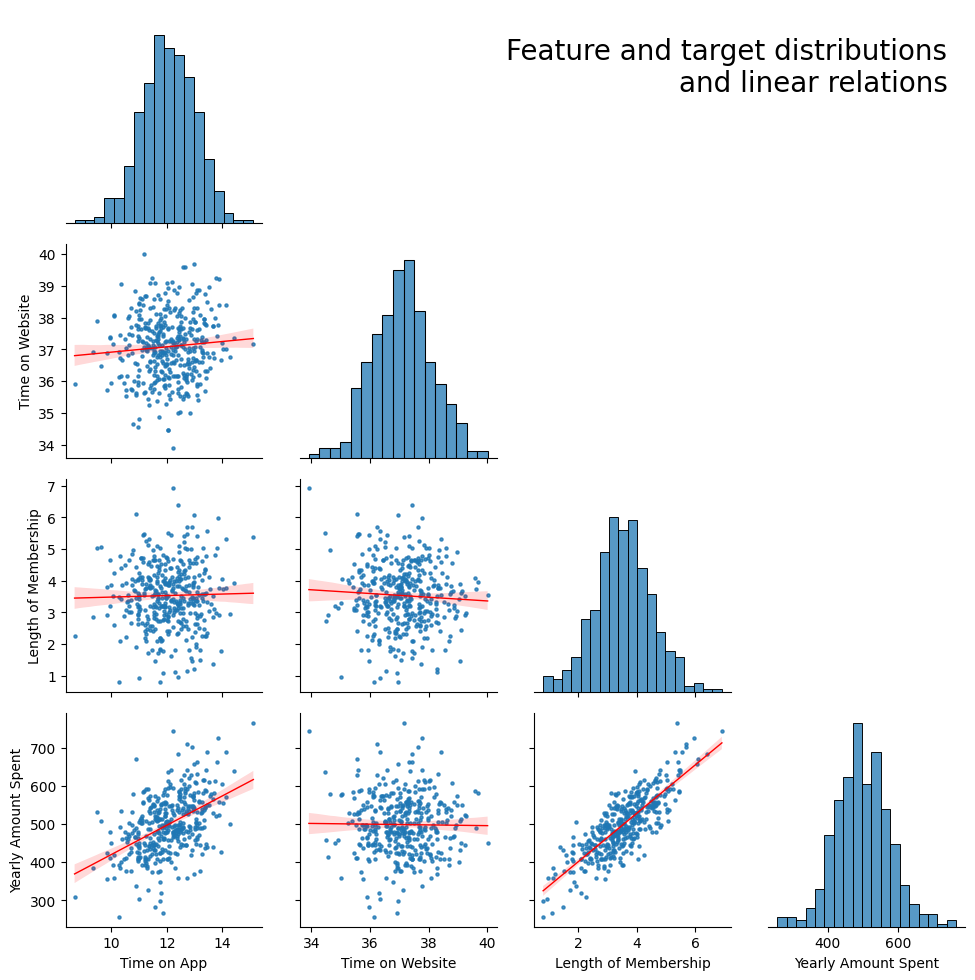

In [4]:
# Pair grid
g = sns.PairGrid(train, corner = True)
g.fig.set_size_inches(10,10)
g.fig.text( 
    x = .95, 
    y = .95,
    s = "Feature and target distributions\nand linear relations",
    ha = "right", 
    va = "top", 
    size = 20,
)

# Histogram
g.map_diag(sns.histplot)

# Linear regression plot
g.map_offdiag(
    sns.regplot, 
    x_ci=95,
    scatter_kws={"s": 5},
    line_kws={"color": "red", 'lw':1}
);

## Pipeline

As the previous pair plot suggests, there is a basis for assuming a strong relationship between the target and some 
of our features.

Linear regression is often sensitive to outliers and its accuracy is highly dependent on feature normalization. To tackle these, we will account for normalization in our pipeline and use [RANSAC](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RANSACRegressor.html#sklearn.linear_model.RANSACRegressor): a linear regression robust to outliers.

In [5]:
pipeline = Pipeline([
    ('MinMaxScaler', MinMaxScaler(clip=True)),              # If we find any abnormal values, this should clip to fit our interval
    ('SimpleImputer', SimpleImputer(strategy='median')),    # If we find null values for unseen data, replace with median
    ('RANSAC', RANSACRegressor(random_state=75)),           # Baseline model
])
pipeline

Pipeline(steps=[('MinMaxScaler', MinMaxScaler(clip=True)),
                ('SimpleImputer', SimpleImputer(strategy='median')),
                ('RANSAC', RANSACRegressor(random_state=75))])

### Modeling and prediction

R² metric is used to evaluate linear regression models. Now that we fit our baseline model using `train` data, we check our results using `test` data. 

In [6]:
def model_fit(clf, X_train, y_train, perform_cv=True, cv_folds=5, perform_val=False):
    "Fits the model of choice, performs CV, and creates a model report"

    # Fit the model
    clf.fit(X_train, y_train)

    # Get predictions
    y_train_predicted = clf.predict(X_train)
    y_test_predicted = clf.predict(X_test)

    print(f"R² on training data: {r2_score(y_train, y_train_predicted ):.5}")
    print(f"Mean squared error on training data {mean_squared_error(y_train, y_train_predicted ):.5}")

    # Perform cross-validation:
    if perform_cv:        
        cv_score = cross_val_score(clf, X_train, y_train, cv=cv_folds, scoring='r2')
        print(f"\nCV Score - Mean: {np.mean(cv_score):.5} | " 
              f"Std: {np.std(cv_score):.5} | "
              f"Min: {np.min(cv_score):.5} | " 
              f"Max: {np.max(cv_score):.5}\n"
             )
        
    # Perform validation:
    if perform_val:
        print(f"R² on test data: {r2_score(y_test, y_test_predicted):.5}")
        print(f"Mean squared error on test data {mean_squared_error(y_test, y_test_predicted):.5}")

    coefficients = pd.Series(
        pipeline['RANSAC'].estimator_.coef_, # type: ignore
        index = pipeline[:-1].get_feature_names_out(),
        name = 'LR coefficients')
    
    return coefficients

model_fit(pipeline, X_train, y_train, perform_val=True)

R² on training data: 0.86639
Mean squared error on training data 808.15

CV Score - Mean: 0.85389 | Std: 0.02256 | Min: 0.829 | Max: 0.89366

R² on test data: 0.90837
Mean squared error on test data 659.11


Time on App             235.406322
Time on Website          -5.428022
Length of Membership    377.873764
Name: LR coefficients, dtype: float64

## Statistical inference

Assuming that our sample is a simple random sample, we check if our sample distributions are normally distributed. The q-q plots confirm the normality assumption. Having satisfied these conditions, we can infer the confidence interval for the means of the overall population.

With 95% certainty, it's possible to say that, for the entire population of users:
- The average `Time on App` ranges from 11.95 to 12.14 hours per week;
- The average `Time on Website` ranges from 36.99 to 37.19 hours per week;
- The average `Length of Membership` ranges from 3.44 to 3.63 years;

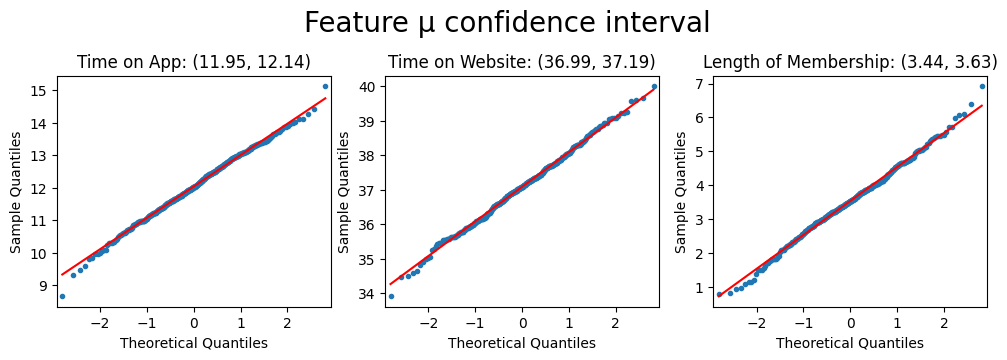

In [32]:
# Check normality assumption with qq-plot and
# calculate 95% confidence interval for feature averages

# Set figure grid
fig, axes = plt.subplots(
    nrows = 1,
    ncols = 3, 
    sharex = True, 
    figsize = (12,3),
)
fig.suptitle('Feature \u03bc confidence interval', size=20, y=1.1)

# Calculate feature CIs and plot them above their qq-plots
for i, feature in enumerate(features):
    ci = sm.stats.DescrStatsW(train[feature]).zconfint_mean() 
    axes[i].set_title(f'{feature}: ({ci[0]:.2f}, {ci[1]:.2f})')
    sm.qqplot(train[feature], line='s', ax=axes[i])
    axes[i].get_lines()[0].set_markersize(3)

## Discussion

By analyzing the given data, one can arrive at the following conclusions, followed by some suggestions that might increase revenue:
- `Length of membership` is an important feature when determining the `Yearly Amount Spent`. It implies that if the company had to focus on either creating new customers or retaining customers, the latter would be advisable because long-time users spend more on the service. On the same note, it might be interesting to display more advertisements for the same population strata.
- The company should focus its investments on the app, seem that `Time on App` has a much stronger correlation to our target.